<a href="https://colab.research.google.com/github/arcbhattx/CSE_176_PROJECT_ML/blob/main/CSE176_part3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/neurodata/SPORF.git

%cd /content/SPORF/Python

!apt-get update
!apt-get install build-essential cmake python3-dev libomp-dev libeigen3-dev   # Ubuntu/Debian


!python setup.py clean --all

!pip install -e .

fatal: destination path 'SPORF' already exists and is not an empty directory.
/content/SPORF/Python
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,917 B in 1s (3,182 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources

In [2]:
# List of imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import kagglehub

# Scikit-learn modules
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# XGBoost
from xgboost import XGBClassifier

# SPORF
from rerf.rerfClassifier import rerfClassifier

# Plot setup
sns.set(style="whitegrid")
%matplotlib inline

Using Colab cache for faster access to the 'magic-gamma-telescope-dataset' dataset.
Dataset Shape: (19020, 11)

Class Distribution (1=Gamma, 0=Hadron):
class
1    0.64837
0    0.35163
Name: proportion, dtype: float64


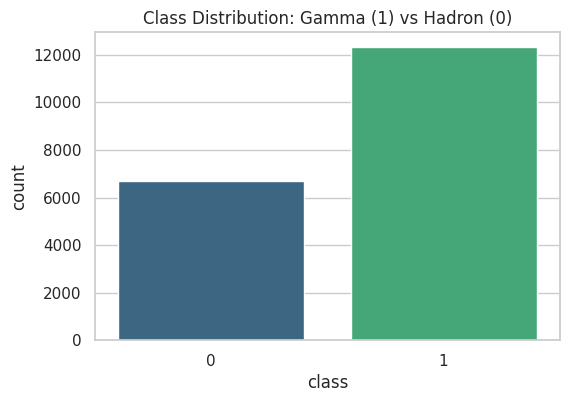

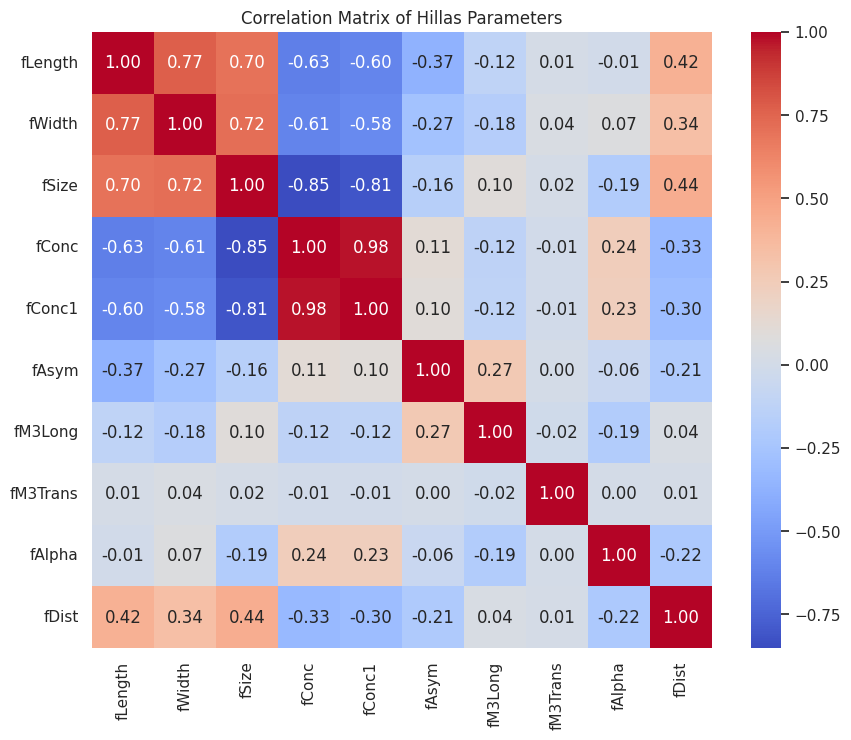

In [3]:
# --- 1. Data Loading ---
# Download dataset (your original code)
path = kagglehub.dataset_download("abhinand05/magic-gamma-telescope-dataset")
df = pd.read_csv(path + '/telescope_data.csv')

df = df.drop(columns=['Unnamed: 0']) # Removes ['Unnamed: 0']

# Mapping: g (signal) -> 1, h (background) -> 0
df['class'] = df['class'].map({'g': 1, 'h': 0})

FEATURES = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym','fM3Long', 'fM3Trans', 'fAlpha', 'fDist']
LABEL = 'class'

# --- 2. Quick Exploratory Data Analysis ---
print("Dataset Shape:", df.shape)
print("\nClass Distribution (1=Gamma, 0=Hadron):")
print(df['class'].value_counts(normalize=True))

# Balance plot
plt.figure(figsize=(6, 4))
sns.countplot(x='class', hue='class', data=df, palette='viridis', legend=False)
plt.title('Class Distribution: Gamma (1) vs Hadron (0)')
plt.show()

# Correlation Matrix (to see relationships between features)
plt.figure(figsize=(10, 8))
sns.heatmap(df[FEATURES].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Hillas Parameters')
plt.show()

In [4]:
X = df[FEATURES].values
y = df[LABEL].values

# First split: Separates the Test Set (20%) from the rest (80%)
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Second split: Separates Validation (20% of total) from Training (60% of total)
# Since X_train_val is 80% of the total, taking 25% of it gives us 20% total.
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val
)

print(f"Training Shape: {X_train.shape} (60%)")
print(f"Validation Shape: {X_val.shape} (20%)")
print(f"Test Shape: {X_test.shape} (20%)")

# --- Scaling ---
# Important: Fit only on training, transform on val and test to avoid Data Leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# X_test_val_scaled = scaler.fit_transform(X_test_val) # For later

Training Shape: (11412, 10) (60%)
Validation Shape: (3804, 10) (20%)
Test Shape: (3804, 10) (20%)


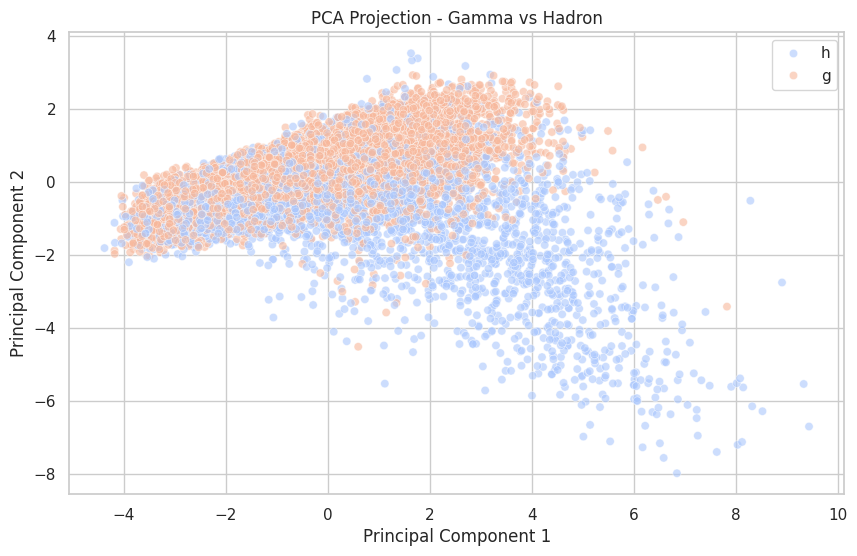

In [5]:
# --- 1. PCA Visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Create descriptive labels for the plot
class_labels = np.array(['h', 'g'])[y_train]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=class_labels, palette='coolwarm', alpha=0.6)
plt.title('PCA Projection - Gamma vs Hadron')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [6]:
# Dictionary of models to test
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gaussian NB": GaussianNB(),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(probability=True, kernel='rbf'), # probability=True is needed for AUC
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "SPORF": rerfClassifier(n_estimators=100, random_state=42)
}

results_baseline = []

print("Training Baselines...")
for name, model in models.items():
    start = time.time()

    # Training (Using scaled data for all for consistency, essential for SVM/KNN)
    model.fit(X_train_scaled, y_train)

    # Prediction on Validation
    y_pred = model.predict(X_val_scaled)
    y_proba = model.predict_proba(X_val_scaled)[:, 1] # Class 1 probability

    elapsed = time.time() - start

    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    results_baseline.append({
        "Model": name,
        "Accuracy": acc,
        "AUC": auc,
        "Time (s)": elapsed
    })
    print(f"Done: {name}")

# Create results DataFrame
df_results = pd.DataFrame(results_baseline).sort_values(by="AUC", ascending=False)
display(df_results)

Training Baselines...
Done: Logistic Regression
Done: Gaussian NB
Done: KNN (k=5)
Done: SVM (RBF)
Done: Random Forest
Done: XGBoost
Done: SPORF


,Model,Accuracy,AUC,Time (s)
4,Random Forest,0.878812,0.929866,6.952997
6,SPORF,0.875394,0.929725,4.210025
5,XGBoost,0.876446,0.925943,0.343929
3,SVM (RBF),0.864616,0.910847,36.679683
2,KNN (k=5),0.827550,0.864642,1.386518
0,Logistic Regression,0.783649,0.823687,0.110375
1,Gaussian NB,0.728970,0.747232,0.028646


In [ ]:
from itertools import product
print("--- Tuning SPORF ---")

# Parameters to test
n_estimators_list = [100, 200, 500]
projection_matrices = ['RerF', 'Base']
max_features_list = [None, "auto", "sqrt","log2"]
feature_combinations_list = [1.5, 2.0, 2.5]

best_auc = 0
best_params = {}
sporf_results = []

# Define the order of parameters for product, excluding unsupported ones
param_names = [
    'n_estimators',
    'projection_matrix',
    'max_features',
    'feature_combinations'
]

PARAMS_TUPLES = list(product(
    n_estimators_list,
    projection_matrices,
    max_features_list,
    feature_combinations_list
))

def custom_roc_auc_scorer(estimator, X, y):
    y_proba = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_proba)

# 1. Robust Cross Validation (on combined Val)
print("Performing 5-fold Cross-Validation on Val...")


for count, param_tuple in enumerate(PARAMS_TUPLES, start=1):
    # Create a dictionary from the tuple for unpacking
    param_dict = dict(zip(param_names, param_tuple))

    # Skip feature_combinations if projection_matrix is 'Base' as it's not applicable
    if param_dict['projection_matrix'] == 'Base':
        # Set feature_combinations to its default for 'Base' to avoid errors or unexpected behavior
        # or simply don't pass it if the model truly doesn't accept it for 'Base'
        temp_param_dict = param_dict.copy()
        _ = temp_param_dict.pop('feature_combinations')
    else:
        temp_param_dict = param_dict.copy()

    print(f"Testing SPORF ({count*100/len(PARAMS_TUPLES):.4f}%)")
    start = time.time()

    # Initialize SPORF with the unpacked dictionary, limiting n_jobs to 1 to prevent crashes during tuning
    clf = rerfClassifier(**temp_param_dict, n_jobs=-1, random_state=42)

    clf.fit(X_train_scaled, y_train)

    try:
      # Cross-validation
      cv_scores = cross_val_score(clf, X_val_scaled, y_val, cv=5, scoring=custom_roc_auc_scorer, n_jobs=1)
      auc = cv_scores.mean()
    except RuntimeWarning as e:
      print(f"RuntimeWarning: {e}")
      # RerF predict_proba returns probabilities
      y_proba = clf.predict_proba(X_val_scaled)[:, 1]
      auc = roc_auc_score(y_val, y_proba)


    elapsed = time.time() - start

    print(f" AUC: {auc:.4f} ({elapsed:.2f}s)")

    # Store the results with the AUC score
    result = param_dict.copy()
    result['AUC'] = auc
    sporf_results.append(result)

    if auc > best_auc:
        best_auc = auc
        best_params = param_dict

print(f"\nBest SPORF parameters found: {best_params} with AUC: {best_auc:.4f}")

--- Tuning SPORF ---
Performing 5-fold Cross-Validation on Val...
Testing SPORF (1.3889%)
 AUC: 0.9210 (22.82s)
Testing SPORF (2.7778%)
 AUC: 0.9187 (23.82s)
Testing SPORF (4.1667%)
 AUC: 0.9204 (26.51s)
Testing SPORF (5.5556%)
 AUC: 0.9165 (6.34s)
Testing SPORF (6.9444%)
 AUC: 0.9174 (8.75s)
Testing SPORF (8.3333%)
 AUC: 0.9163 (9.21s)
Testing SPORF (9.7222%)
 AUC: 0.9165 (6.40s)
Testing SPORF (11.1111%)
 AUC: 0.9174 (8.71s)
Testing SPORF (12.5000%)
 AUC: 0.9163 (7.90s)
Testing SPORF (13.8889%)
 AUC: 0.9165 (7.64s)
Testing SPORF (15.2778%)
 AUC: 0.9174 (8.93s)
Testing SPORF (16.6667%)
 AUC: 0.9163 (8.00s)
Testing SPORF (18.0556%)
 AUC: 0.9141 (20.65s)
Testing SPORF (19.4444%)
 AUC: 0.9141 (18.33s)
Testing SPORF (20.8333%)
 AUC: 0.9141 (18.33s)
Testing SPORF (22.2222%)
 AUC: 0.9173 (6.86s)
Testing SPORF (23.6111%)
 AUC: 0.9173 (5.60s)
Testing SPORF (25.0000%)
 AUC: 0.9173 (6.98s)
Testing SPORF (26.3889%)
 AUC: 0.9173 (6.29s)
Testing SPORF (27.7778%)
 AUC: 0.9173 (6.95s)
Testing SPORF (

In [ ]:
col_attrs = ['n_estimators', 'projection_matrix']
row_attrs = ['max_features', 'feature_combinations']
value_col = 'AUC'

# Plot singular correlation parameter-AOC
sporf_results = pd.DataFrame(sporf_results)
sporf_results['max_features'] = sporf_results['max_features'].replace({None: 'none'})

# 3) Pivot: crea la tabella con MultiIndex su righe e colonne
table = sporf_results.pivot_table(
    index=row_attrs,
    columns=col_attrs,
    values=value_col
)

sns.heatmap(table, annot=True, fmt=".3f", cmap='coolwarm')
plt.title("SPORF Hyperparameter Tuning Results")
plt.show()

In [ ]:
# --- 2. Feature Importance (Permutation) ---
# Using the best SPORF model found
print(f"Best SPORF parameters: {best_params}")
best_sporf = rerfClassifier(**best_params, n_jobs=-1, random_state=42)
best_sporf.fit(X_train_scaled, y_train)

result_perm = permutation_importance(best_sporf, X_val_scaled, y_val, n_repeats=10, random_state=42)
sorted_idx = result_perm.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result_perm.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [FEATURES[i] for i in sorted_idx])
plt.xlabel("Permutation Importance (Drop in Accuracy)")
plt.title("Which Hillas parameters matter most for SPORF?")
plt.show()

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print("--- Executing LDA Experiment ---")

# 1. LDA Application
# LDA reduces to (n_classes - 1) dimensions. Here we have 2 classes -> 1 dimension.
lda = LinearDiscriminantAnalysis(n_components=1)

# Fit only on the scaled training set
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled) # We also transform the test set for later

# 2. Separation Visualization
# We create a histogram to see if the two classes have separated
plt.figure(figsize=(10, 6))
plt.hist(X_train_lda[y_train==0], bins=30, alpha=0.6, label='Noise (Hadron)', color='blue', density=True)
plt.hist(X_train_lda[y_train==1], bins=30, alpha=0.6, label='Signal (Gamma)', color='red', density=True)
plt.title("Data Projection on the LDA Discriminant Axis")
plt.xlabel("LDA Value")
plt.ylabel("Density")
plt.legend()
plt.show()

print("If you see two well-separated 'mountains' (red and blue), LDA has found an excellent discriminant axis!")

In [ ]:
from sklearn.metrics import roc_auc_score

# Define a custom scoring function
def custom_roc_auc_scorer(estimator, X, y):
    y_proba = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_proba)

# 1. Robust Cross Validation (on combined Train+Val)
print("Performing 5-fold Cross-Validation on Val...")
# Setting n_jobs=1 to avoid ModuleNotFoundError when pickling rerfClassifier to child processes.
cv_scores = cross_val_score(best_sporf, X_val_scaled, y_val, cv=5, scoring=custom_roc_auc_scorer, n_jobs=1)
print(f"Cross-Validation AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 2. Final Training and Test
print("\nFinal training of optimal SPORF model...")
start_final = time.time()
best_sporf.fit(X_val_scaled, y_val) # Train on 80% data
y_test_pred = best_sporf.predict(X_test_scaled)
y_test_proba = best_sporf.predict_proba(X_test_scaled)[:, 1]
time_final = time.time() - start_final

print(f"Test Set AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Test Set Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

In [ ]:
# --- 1. ROC Curve Comparison ---
plt.figure(figsize=(10, 8))

# SPORF ROC
fpr_sporf, tpr_sporf, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr_sporf, tpr_sporf, label=f"SPORF (AUC = {roc_auc_score(y_test, y_test_proba):.3f})", linewidth=3)

# Random Forest ROC (retrain on val for fair comparison)
rf_final = RandomForestClassifier(n_estimators=100).fit(X_train_scaled, y_train)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_final.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr_rf, tpr_rf, linestyle='--', label=f"Random Forest (AUC = {roc_auc_score(y_test, rf_final.predict_proba(X_test_scaled)[:, 1]):.3f})")

# XGBoost ROC
xgb_final = XGBClassifier(eval_metric='logloss').fit(X_train_scaled, y_train)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_final.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr_xgb, tpr_xgb, linestyle=':', label=f"XGBoost (AUC = {roc_auc_score(y_test, xgb_final.predict_proba(X_test_scaled)[:, 1]):.3f})")

# Random line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.xlabel('False Positive Rate (Background accepted as Signal)')
plt.ylabel('True Positive Rate (Signal efficiency)')
plt.title('ROC Curve Comparison: SPORF vs Baselines')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score

# --- Threshold Analysis (False Positive Management) ---

# Predicted probabilities on the test set
y_proba_test = best_sporf.predict_proba(X_test_scaled)[:, 1]

# Youden's optimal treshold
def youden_t():
  fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
  j_scores = tpr - fpr
  optimal_idx = np.argmax(j_scores)
  return thresholds[optimal_idx]

# We define two thresholds: Standard (0.5) and Conservative (e.g., 0.85)
thresholds = [0.5, youden_t(), 0.8]

plt.figure(figsize=(12, 5))

for i, thresh in enumerate(thresholds):
    # Create predictions based on the threshold
    y_pred_custom = (y_proba_test >= thresh).astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_custom)

    # Specific metrics
    prec = precision_score(y_test, y_pred_custom)
    rec = recall_score(y_test, y_pred_custom)

    # Plot
    plt.subplot(1, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Hadron (Pred)', 'Gamma (Pred)'],
                yticklabels=['Hadron (True)', 'Gamma (True)'])
    plt.title(f"Threshold = {thresh}\nPrecision: {prec:.2f} | Recall: {rec:.2f}")

    # Highlight the critical number: False Positives (Top Right)
    fp_count = cm[0, 1]
    plt.xlabel(f"False Positives: {fp_count} (Lower is better)")

plt.tight_layout()
plt.show()

In [ ]:
# Remove the worst features from your plot (< .025)
features_to_drop = ['fM3Trans', 'fAsym']
features_selected = [f for f in FEATURES if f not in features_to_drop]

print(f"Training SPORF with only the best features: {features_selected}")

# You need to re-subset the columns
idx_keep = [FEATURES.index(f) for f in features_selected]
X_train_sel = X_train_scaled[:, idx_keep]
X_test_sel = X_test_scaled[:, idx_keep]

# Quick test
clf_sel = rerfClassifier(**best_params, random_state=42, n_jobs=1)
clf_sel.fit(X_train_sel, y_train)
roc_auc_score_sel = roc_auc_score(y_test, clf_sel.predict(X_test_sel))
print(f"New AUC (Feature Selection): {roc_auc_score_sel:.4f}")

In [ ]:
# --- 1. ROC Curve Comparison ---
plt.figure(figsize=(10, 8))

# REMOVE from models the the first istance SPORF in modles
if 'SPORF' in models:
  models.pop('SPORF')

# Plot SPORF ROC (already trained and probabilities available from a previous cell)
fpr_sporf, tpr_sporf, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr_sporf, tpr_sporf, label=f"SPORF (AUC = {roc_auc_score(y_test, y_test_proba):.3f})", linewidth=3, color='darkorange') # Using a distinct color

# Define linestyles to cycle through for better visual distinction
linestyles = ['--', ':', '-.', (0, (3, 5, 1, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (5, 10))]
style_idx = 0

# Loop through all models in the dictionary, train them on the combined data, and plot their ROC curves
for name, model_instance in models.items():
    print(f"Training and evaluating {name} for ROC plot...")

    # Train on train set
    model_instance.fit(X_train_scaled, y_train)

    # Predict probabilities on the test set
    y_proba_model = model_instance.predict_proba(X_test_scaled)[:, 1]

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba_model)
    auc_score = roc_auc_score(y_test, y_proba_model)

    # Plot the ROC curve, cycling through linestyles
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})", linestyle=linestyles[style_idx % len(linestyles)])
    style_idx += 1

# Plot the random classifier line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

plt.xlabel('False Positive Rate (Background accepted as Signal)')
plt.ylabel('True Positive Rate (Signal efficiency)')
plt.title('ROC Curve Comparison: All Models')
plt.legend(loc="lower right")
plt.show()